# Exploring neural cell types in ASD

We will perform group and individual-level gene ("X")-set enrichment analyses on autism spectrum disorder (ASD) case-control data. 

First, we will fetch a parcellated ABIDE-I resting-state brain activity dataset, shipped as an example dataset with `NiSpace`. Additionally, we will download some t-maps published by a prior study looking at replicability of case-control differences in ASD. As reference dataset, we will use the Allen Brain Atlas gene expression data with a cell type marker collection included with `NiSpace`.

After covariate regression and site-harmonization, we will perform X-set enrichment colocalization analyses on an ABIDE cohort-level alteration map as well as on alteration maps for each individual ASD subject. Analyses on the downloaded t-maps serve to demonstrate replicability of our results.

In [1]:
# general imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# monkey patch to make progress bars show as ASCII instead of as widgets
import tqdm.notebook
tqdm.notebook.tqdm = tqdm.tqdm

## Fetch the ABIDE I example dataset

The ABIDE I dataset shipped with `NiSpace` contains parcellated fALFF data (Schaefer200MelbourneS2) downloaded using nilearn's `fetch_abide_pcp()` function. See the API documentation for detailed info.

In [2]:
from nispace.datasets import fetch_example

# fetch the parcellated data and corresponding phenotypic info
abide_data, abide_pheno = fetch_example("abide")
abide_pheno = abide_pheno.set_index("subject")
display(abide_pheno.shape, abide_pheno.head(5))
display(abide_data.shape, abide_data.head(5))

# we provide the ABIDE dataset parcellated with the integrated "Schaefer200MelbourneS2" parcellation
parc_name = "Schaefer200MelbourneS2"

# get ABIDE groups: column 'dx' in the pheno data; for clarity, we use a numeric vector with
# ASD = 0 and CTRL = 1.
abide_groups = abide_pheno.dx.map({"ASD": 0, "CTRL": 1}).to_list()

INFO | 21/06/24 22:01:38 | nispace: Loading example dataset: abide
INFO | 21/06/24 22:01:38 | nispace: The abide dataset was parcellated using the Schaefer200MelbourneS2 parcellation.
INFO | 21/06/24 22:01:38 | nispace: Returning parcellated and associated subject data.


(871, 18)

,site,site_num,dx,dx_num,dsm_iv_tr,age,sex,sex_num,qc_rater_1,qc_func_rater_2,qc_func_rater_3,adi_r_social_total_a,adi_r_verbal_total_bv,adi_rrb_total_c,ados_total,srs_raw_total,scq_total,aq_total
subject,,,,,,,,,,,,,,,,,,
50003,PITT,9,ASD,1,1.0,24.45,M,1,OK,OK,OK,27.0,22.0,5.0,13.0,NaN,NaN,NaN
50004,PITT,9,ASD,1,1.0,19.09,M,1,OK,OK,OK,19.0,12.0,5.0,18.0,NaN,NaN,NaN
50005,PITT,9,ASD,1,1.0,13.73,F,2,OK,maybe,OK,23.0,19.0,3.0,12.0,NaN,NaN,NaN
50006,PITT,9,ASD,1,1.0,13.37,M,1,OK,maybe,OK,13.0,10.0,4.0,12.0,NaN,NaN,NaN
50007,PITT,9,ASD,1,1.0,17.78,M,1,OK,maybe,OK,21.0,14.0,9.0,17.0,NaN,NaN,NaN


(871, 232)

,1_RH_SC_aHIP,2_RH_SC_pHIP,3_RH_SC_lAMY,4_RH_SC_mAMY,5_RH_SC_THA-DP,6_RH_SC_THA-VP,7_RH_SC_THA-VA,8_RH_SC_THA-DA,9_RH_SC_NAc-shell,10_RH_SC_NAc-core,...,223_RH_CX_Default_PFCdPFCm_1,224_RH_CX_Default_PFCdPFCm_2,225_RH_CX_Default_PFCdPFCm_3,226_RH_CX_Default_PFCdPFCm_4,227_RH_CX_Default_PFCdPFCm_5,228_RH_CX_Default_PFCdPFCm_6,229_RH_CX_Default_PFCdPFCm_7,230_RH_CX_Default_pCunPCC_1,231_RH_CX_Default_pCunPCC_2,232_RH_CX_Default_pCunPCC_3
subject,,,,,,,,,,,,,,,,,,,,,
50003,0.554244,0.545724,0.540651,0.567798,0.565456,0.549855,0.575414,0.547232,0.556550,0.549233,...,0.511879,0.546551,0.572870,0.489960,0.481450,0.548910,0.553655,0.630450,0.624178,0.629993
50004,0.480016,0.507608,0.501729,0.479775,0.497517,0.496894,0.508031,0.504987,0.518331,0.529840,...,0.499219,0.514022,0.495265,0.535245,0.531300,0.530919,0.544821,0.531825,0.549992,0.583247
50005,0.498510,0.525765,0.504602,0.533165,0.526105,0.517529,0.539943,0.543338,0.560928,0.557962,...,0.539904,0.570698,0.539725,0.570238,0.521150,0.535021,0.549574,0.590597,0.604462,0.599347
50006,0.521442,0.536580,0.508965,0.523906,0.534811,0.522690,0.525827,0.522897,0.535364,0.525703,...,0.553780,0.543042,0.518454,0.561790,0.522045,0.552814,0.528958,0.580796,0.581530,0.590443
50007,0.540955,0.565601,0.538194,0.572868,0.570920,0.538686,0.572898,0.567324,0.581634,0.585195,...,0.584967,0.598638,0.561605,0.603095,0.533502,0.589898,0.550674,0.575307,0.609521,0.621164


## Fetch multi-cohort ASD t-maps from Holiga et al., 2019

We download cohort-level t-maps, contrasting ASD vs. control participants in four independent cohorts: ["Patients with autism spectrum disorders display reproducible functional connectivity alterations"](https://doi.org/10.1126/scitranslmed.aat9223). The data is on neurovault so we can use nilearn's `fetch_neurovault_ids` function.

In [45]:
from nilearn.datasets import fetch_neurovault_ids

holiga_dict = fetch_neurovault_ids([5769])
holiga_data = holiga_dict["images"]

print("Downloaded files:")
display(holiga_data)

print("Names:")
holiga_labels = [dic["name"].split(" ")[-1] for dic in holiga_dict["images_meta"]]
holiga_labels

Reading local neurovault data.
Already fetched 1 image
Already fetched 2 images
Already fetched 3 images
Already fetched 4 images
4 images found on local disk.
Downloaded files:


['/Users/llotter/nilearn_data/neurovault/collection_5769/image_134189.nii.gz',
 '/Users/llotter/nilearn_data/neurovault/collection_5769/image_134190.nii.gz',
 '/Users/llotter/nilearn_data/neurovault/collection_5769/image_134191.nii.gz',
 '/Users/llotter/nilearn_data/neurovault/collection_5769/image_134188.nii.gz']

Names:


['ABIDE2', 'EUAIMS', 'INFOR', 'ABIDE']

## Fetch reference data

We want to perform gene ("X")-set enrichment analyses to see if resting-state fMRI alterations in ASD share spatial patterns with genetic markers of specific neural cell types. For this, we need to fetch the mRNA dataset with a cell type "collection". As commonly done in gene-set enrichment analyses, we will estimate non-parametric p values by evaluating colocalization ("enrichment") patterns with randomly selected gene sets. For this, we will need to provide a "background" gene set. Here, we just use the full mRNA dataset provided with `NiSpace`.

In [3]:
from nispace.datasets import fetch_reference

# get cell type data
ref_data = fetch_reference(
    "mrna", 
    collection="CellTypesPsychEncodeUMI", 
    parcellation=parc_name,
    print_references=False
)
display(ref_data.shape, ref_data.head(5))

# get number of maps/gene markers per set/cell type
ref_data_maps_pet_set = ref_data.index.get_level_values("set").value_counts()
print(f"Between {ref_data_maps_pet_set.min()} and {ref_data_maps_pet_set.max()} maps per set")

# get all genes as background
ref_background = fetch_reference(
    "mrna", parcellation=parc_name,
    print_references=False
)

INFO | 21/06/24 22:12:16 | nispace: Loading mrna maps.
INFO | 21/06/24 22:12:16 | nispace: Applying collection filter from: /Users/llotter/nispace-data/reference/mrna/collection-CellTypesPsychEncodeUMI.json.
INFO | 21/06/24 22:12:19 | nispace: Loading parcellated data: Schaefer200MelbourneS2
INFO | 21/06/24 22:12:19 | nispace: Standardizing parcellated data.


(4655, 232)

1_RH_SC_aHIP  2_RH_SC_pHIP  3_RH_SC_lAMY  4_RH_SC_mAMY  \
set map                                                              
Ex1 ABI2       -1.042726     -2.065989     -1.515578     -1.612650   
    ABLIM2     -2.596277     -2.250765     -2.385903     -2.193684   
    ACTN1       0.972212     -0.317960      0.201232      0.315914   
    ADCY1      -1.381187     -1.024309     -2.580933     -1.127108   
    ADGRL2     -0.984087     -1.467544     -0.814394      0.059242   

            5_RH_SC_THA-DP  6_RH_SC_THA-VP  7_RH_SC_THA-VA  8_RH_SC_THA-DA  \
set map                                                                      
Ex1 ABI2         -3.483838       -3.566566       -3.413741       -3.287737   
    ABLIM2       -2.423220       -2.376298       -2.491786       -2.146743   
    ACTN1        -1.903334       -3.051351       -2.726332       -2.236583   
    ADCY1        -1.967965       -2.317488       -2.760067       -2.404508   
    ADGRL2       -2.624866       -2.798730       -2.144579       -2.987957   

            9_RH_SC_NAc-shell  10_RH_SC_NAc-core  ...  \
set map                                           ...   
Ex1 ABI2            -0.576106           2.022070  ...   
    ABLIM2          -0.149540           2.481432  ...   
    ACTN1            0.312840           3.452626  ...   
    ADCY1           -3.169779          -2.555039  ...   
    ADGRL2          -0.909383          -2.302124  ...   

            223_RH_CX_Default_PFCdPFCm_1  224_RH_CX_Default_PFCdPFCm_2  \
set map                                                                  
Ex1 ABI2                        0.830340                      1.255790   
    ABLIM2                     -0.446393                     -1.369552   
    ACTN1                      -0.160700                     -0.009525   
    ADCY1                      -0.179846                     -0.661450   
    ADGRL2                     -0.638359                     -0.415581   

            225_RH_CX_Default_PFCdPFCm_3  226_RH_CX_Default_PFCdPFCm_4  \
set map                                                                  
Ex1 ABI2                        0.809311                      0.340092   
    ABLIM2                     -2.285183                     -0.197329   
    ACTN1                      -2.117091                      0.526506   
    ADCY1                      -0.402406                      0.136552   
    ADGRL2                     -1.406796                      0.067488   

            227_RH_CX_Default_PFCdPFCm_5  228_RH_CX_Default_PFCdPFCm_6  \
set map                                                                  
Ex1 ABI2                        0.358225                      0.971207   
    ABLIM2                     -0.145569                      0.435307   
    ACTN1                      -0.133745                      0.772281   
    ADCY1                       0.154469                      0.270981   
    ADGRL2                     -0.414828                     -0.727168   

            229_RH_CX_Default_PFCdPFCm_7  230_RH_CX_Default_pCunPCC_1  \
set map                                                                 
Ex1 ABI2                       -0.030936                    -0.371451   
    ABLIM2                     -0.132745                    -0.573681   
    ACTN1                       0.318213                    -0.530108   
    ADCY1                       0.479067                    -0.776696   
    ADGRL2                     -0.481105                    -0.314574   

            231_RH_CX_Default_pCunPCC_2  232_RH_CX_Default_pCunPCC_3  
set map                                                               
Ex1 ABI2                      -0.085319                     0.081669  
    ABLIM2                     0.404667                     0.707350  
    ACTN1                      0.481453                     0.316335  
    ADCY1                      0.421783                     0.395162  
    ADGRL2                     0.644048                     0.659893  

[5 rows

Between 53 and 312 maps per set
INFO | 21/06/24 22:12:19 | nispace: Loading mrna maps.
INFO | 21/06/24 22:12:19 | nispace: Loading parcellated data: Schaefer200MelbourneS2
INFO | 21/06/24 22:12:19 | nispace: Standardizing parcellated data.


## Initialize `NiSpace`

We fit NiSpace with the prepared data. The argument `z="gm"` will 

In [47]:
from nispace import NiSpace

nsp = NiSpace(
    x=ref_data,
    y=abide_data,
    z="gm",
    parcellation=parc_name,
    standardize="xyz",
    n_proc=-1,
).fit()

# we will store our results in dictionaries:
colocs, p_values, q_values = {}, {}, {}


INFO | 17/06/24 09:27:57 | nispace: *** NiSpace.fit() - Data extraction and preparation. ***
INFO | 17/06/24 09:27:57 | nispace: Loading parcellation: Schaefer200MelbourneS2 (n: 232, space: mni152, res: 1mm)
INFO | 17/06/24 09:27:57 | nispace: Loaded integrated parcellation with pre-calculated distance matrix.
INFO | 17/06/24 09:27:57 | nispace: Checking input data for 'x' (should be, e.g., PET data):
INFO | 17/06/24 09:27:57 | nispace: Input type: DataFrame, assuming parcellated data with shape (n_files/subjects/etc, n_parcels).
INFO | 17/06/24 09:27:57 | nispace: Got 'x' data for 2030 x 232 parcels.
INFO | 17/06/24 09:27:57 | nispace: Checking input data for 'y' (should be, e.g., subject data):
INFO | 17/06/24 09:27:57 | nispace: Input type: DataFrame, assuming parcellated data with shape (n_files/subjects/etc, n_parcels).
WARNING | 17/06/24 09:27:57 | nispace: Parcellated data contains nan values!
INFO | 17/06/24 09:27:57 | nispace: Got 'y' data for 871 x 232 parcels.
INFO | 17/06/2

Parcellating (-1 proc):   0%|          | 0/1 [00:00<?, ?it/s]

INFO | 17/06/24 09:28:01 | nispace: Combined across images, 0 parcels had only background intensity and were set to nan (indices: []).
INFO | 17/06/24 09:28:01 | nispace: Got 'z' data for 1 x 232 parcels.
INFO | 17/06/24 09:28:01 | nispace: Z-standardizing 'X' data.
INFO | 17/06/24 09:28:01 | nispace: Z-standardizing 'Y' data.
INFO | 17/06/24 09:28:01 | nispace: Z-standardizing 'Z' data.


## Clean the data

In [48]:
covariates = pd.DataFrame({
    "age": abide_pheno.age,
    "sex": abide_pheno.sex_num,
    "site": abide_pheno.site_num,
    "dx": abide_pheno.dx_num
})

nsp.clean_y(
    how=["between", "within"],
    covariates_between=covariates,
    covariates_within="z",
    combat=True,
    combat_keep="dx"
)

INFO | 17/06/24 09:28:01 | nispace: *** NiSpace.clean_y() - Y covariate regression. ***
INFO | 17/06/24 09:28:01 | nispace: Performing covariate regression within map/subjects (e.g., grey matter maps).
INFO | 17/06/24 09:28:01 | nispace: Using Z data for 'within' covariate regression.


Regressing within covariate(s) on Y (-1 proc):   0%|          | 0/871 [00:00<?, ?it/s]

INFO | 17/06/24 09:28:06 | nispace: Performing covariate regression between maps/subjects (e.g., age, sex, site).
INFO | 17/06/24 09:28:06 | nispace: Assuming 4 'between' covariate(s) for 871 maps/subjects.


Regressing 2 between covariate(s) on Y (-1 proc):   0%|          | 0/232 [00:00<?, ?it/s]

INFO | 17/06/24 09:28:07 | nispace: Performing combat harmonization, retaining 1 covariates.
WARNING | 17/06/24 09:28:07 | nispace: Detected missing values in Y data, which is not supported with ComBat harmonization. Missing values will be imputed with map-wise medians and replaced by nan after harmonization. CAVE: experimental feature!


,1_RH_SC_aHIP,2_RH_SC_pHIP,3_RH_SC_lAMY,4_RH_SC_mAMY,5_RH_SC_THA-DP,6_RH_SC_THA-VP,7_RH_SC_THA-VA,8_RH_SC_THA-DA,9_RH_SC_NAc-shell,10_RH_SC_NAc-core,...,223_RH_CX_Default_PFCdPFCm_1,224_RH_CX_Default_PFCdPFCm_2,225_RH_CX_Default_PFCdPFCm_3,226_RH_CX_Default_PFCdPFCm_4,227_RH_CX_Default_PFCdPFCm_5,228_RH_CX_Default_PFCdPFCm_6,229_RH_CX_Default_PFCdPFCm_7,230_RH_CX_Default_pCunPCC_1,231_RH_CX_Default_pCunPCC_2,232_RH_CX_Default_pCunPCC_3
subject,,,,,,,,,,,,,,,,,,,,,
50003,0.167689,-0.084155,0.051752,0.233067,0.101182,0.108224,0.249810,-0.273485,-0.135987,-0.320375,...,-0.282843,-0.699702,0.394355,-1.517158,-1.246286,-0.384176,-0.200047,0.244294,0.096392,-0.094282
50004,-0.587273,0.100088,0.272959,-0.729547,-0.575836,-0.321702,-0.288194,-0.314580,0.279452,0.498872,...,0.148428,-0.372394,-0.726073,0.184374,0.336615,0.194882,0.711172,-0.297480,0.054986,0.704408
50005,-0.637845,-0.115168,-0.455848,-0.128779,-0.341972,-0.177017,-0.104366,0.001750,0.322817,0.262834,...,0.479101,0.267850,-0.002983,0.232324,-0.322074,-0.340664,0.138898,0.149681,0.327614,-0.019387
50006,-0.063169,0.289578,-0.333437,-0.172965,-0.062639,-0.106463,-0.409640,-0.438675,-0.041588,-0.336104,...,0.939598,-0.282912,-0.611751,0.102232,-0.475134,0.092706,-0.429793,0.217372,0.092604,0.024411
50007,-0.395613,0.075817,-0.454587,0.086703,-0.025711,-0.437160,-0.048160,-0.154314,0.119768,0.159674,...,0.807588,0.144353,-0.202088,0.174166,-0.805522,0.152390,-0.611326,-0.804575,-0.314684,-0.322547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51583,0.107548,0.325971,-0.008590,0.059325,0.189069,0.403414,0.384029,0.228940,0.206096,0.431475,...,0.251486,-0.015500,0.465482,0.312418,0.040566,0.200273,-0.202745,-0.412147,-0.423343,-0.282969
51584,-0.664540,-0.849750,-0.027073,-0.198110,-0.633849,-0.705904,-0.556987,-0.648233,-0.215659,-0.211732,...,-0.175822,-0.674090,-1.110144,-0.288856,-0.579372,-0.837788,-0.447385,0.397223,0.308494,0.095759
51585,0.041093,0.247226,-0.248463,-0.010431,0.927408,1.006914,0.851825,0.990590,-0.011467,-0.202861,...,0.666568,0.304125,0.640565,-0.043777,-0.001441,0.169611,0.052183,-0.236446,-0.508611,-0.207281


## Run colocalizations of case-control maps

In [49]:
colocalization = "spearman"

for comparison in ["hedges(a,b)", "zscore(a,b)"]:
    # Transform Y
    nsp.transform_y(
        comparison,
        groups=abide_groups
    )
    # Run colocalization 
    nsp.colocalize(
        colocalization, 
        Y_transform=comparison,
        xsea=True
    )
    # Run permutation
    nsp.permute(
        "sets",
        colocalization,
        sets_X_background=ref_background,
        Y_transform=comparison,
        n_perm=1000
    )
    # Correct p values
    nsp.correct_p(
        mc_method="fdr",
    )
    # Save
    colocs[comparison] = nsp.get_colocalizations(method=colocalization, Y_transform=comparison)
    p_values[comparison] = nsp.get_p_values(method=colocalization, Y_transform=comparison)
    q_values[comparison] = nsp.get_p_values(method=colocalization, Y_transform=comparison, mc_method="fdrbh", norm=True)

INFO | 17/06/24 09:28:07 | nispace: *** NiSpace.transform_y() - Y transformation and comparison. ***
INFO | 17/06/24 09:28:07 | nispace: Groups/sessions vector provided, ensuring dummy-coding.
INFO | 17/06/24 09:28:07 | nispace: Applying Y transform 'hedges(a,b)'.
INFO | 17/06/24 09:28:07 | nispace: *** NiSpace.colocalize() - Estimating X & Y colocalizations. ***
INFO | 17/06/24 09:28:07 | nispace: Running 'spearman' colocalization with 'hedges(a,b)' transform.
INFO | 17/06/24 09:28:07 | nispace: Will perform X-set enrichment analysis (XSEA).
INFO | 17/06/24 09:28:07 | nispace: Using 14 sets with between 53 and 193 samples. Aggregating within-set colocalizations with: mean.
INFO | 17/06/24 09:28:07 | nispace: Will regress Z from Y before colocalization calculation.
WARNING | 17/06/24 09:28:07 | nispace: It seems, Z regression was performed using NiSpace.clean_y(). Will not perform Z regression.


Colocalizing (spearman, -1 proc):   0%|          | 0/1 [00:00<?, ?it/s]

INFO | 17/06/24 09:28:08 | nispace: *** NiSpace.permute() - Estimate exact non-parametric p values. ***
INFO | 17/06/24 09:28:08 | nispace: Permutation of: X sets.
INFO | 17/06/24 09:28:08 | nispace: Loading transformed Y data, transform = 'hedges(a,b)'.
INFO | 17/06/24 09:28:08 | nispace: Will calculate p values for mean calculation across Y maps. Set 'p_from_average_y_coloc' = False to change this behavior.
INFO | 17/06/24 09:28:08 | nispace: Loading observed colocalizations (method = 'spearman').
INFO | 17/06/24 09:28:08 | nispace: Generating permuted X sets.
INFO | 17/06/24 09:28:08 | nispace: Will use 11432 provided background maps.
INFO | 17/06/24 09:28:08 | nispace: Z-standardizing X background maps.


Permuting X set indices:   0%|          | 0/1000 [00:00<?, ?it/s]

Null colocalizations (spearman, -1 proc):   0%|          | 0/1000 [00:00<?, ?it/s]

INFO | 17/06/24 09:28:16 | nispace: Calculating exact p-values (tails = {'rho': 'two'}).
INFO | 17/06/24 09:28:16 | nispace: *** NiSpace.correct_p() - Correct p values for multiple comparisons. ***
INFO | 17/06/24 09:28:16 | nispace: Returning colocalizations: 
| METHOD   | XSEA | X_REDUCTION | Y_TRANSFORM | 
| spearman | True | False       | hedges(a,b) | 
INFO | 17/06/24 09:28:16 | nispace: Returning p values: 
| METHOD   | PERMUTE_WHAT | XSEA | MC_METHOD | NORM  | X_REDUCTION | Y_TRANSFORM | 
| spearman | sets         | True | None      | False | False       | hedges(a,b) | 
INFO | 17/06/24 09:28:16 | nispace: Returning p values: 
| METHOD   | PERMUTE_WHAT | XSEA | MC_METHOD | NORM | X_REDUCTION | Y_TRANSFORM | 
| spearman | sets         | True | fdrbh     | True | False       | hedges(a,b) | 
INFO | 17/06/24 09:28:16 | nispace: *** NiSpace.transform_y() - Y transformation and comparison. ***
INFO | 17/06/24 09:28:16 | nispace: Groups/sessions vector provided, ensuring dummy-coding.

Colocalizing (spearman, -1 proc):   0%|          | 0/403 [00:00<?, ?it/s]

INFO | 17/06/24 09:28:18 | nispace: *** NiSpace.permute() - Estimate exact non-parametric p values. ***
INFO | 17/06/24 09:28:18 | nispace: Permutation of: X sets.
INFO | 17/06/24 09:28:18 | nispace: Loading transformed Y data, transform = 'zscore(a,b)'.
INFO | 17/06/24 09:28:18 | nispace: Will calculate p values for mean calculation across Y maps. Set 'p_from_average_y_coloc' = False to change this behavior.
INFO | 17/06/24 09:28:18 | nispace: Loading observed colocalizations (method = 'spearman').
INFO | 17/06/24 09:28:18 | nispace: Generating permuted X sets.
INFO | 17/06/24 09:28:18 | nispace: Will use 11432 provided background maps.
INFO | 17/06/24 09:28:18 | nispace: Z-standardizing X background maps.


Permuting X set indices:   0%|          | 0/1000 [00:00<?, ?it/s]

Null colocalizations (spearman, -1 proc):   0%|          | 0/1000 [00:00<?, ?it/s]

INFO | 17/06/24 10:01:48 | nispace: Calculating exact p-values (tails = {'rho': 'two'}).
INFO | 17/06/24 10:01:48 | nispace: *** NiSpace.correct_p() - Correct p values for multiple comparisons. ***
INFO | 17/06/24 10:01:48 | nispace: Returning colocalizations: 
| METHOD   | XSEA | X_REDUCTION | Y_TRANSFORM | 
| spearman | True | False       | zscore(a,b) | 
INFO | 17/06/24 10:01:48 | nispace: Returning p values: 
| METHOD   | PERMUTE_WHAT | XSEA | MC_METHOD | NORM  | X_REDUCTION | Y_TRANSFORM | 
| spearman | sets         | True | None      | False | False       | zscore(a,b) | 
INFO | 17/06/24 10:01:48 | nispace: Returning p values: 
| METHOD   | PERMUTE_WHAT | XSEA | MC_METHOD | NORM | X_REDUCTION | Y_TRANSFORM | 
| spearman | sets         | True | fdrbh     | True | False       | zscore(a,b) | 


## Replicability in Holiga2019 group-average data

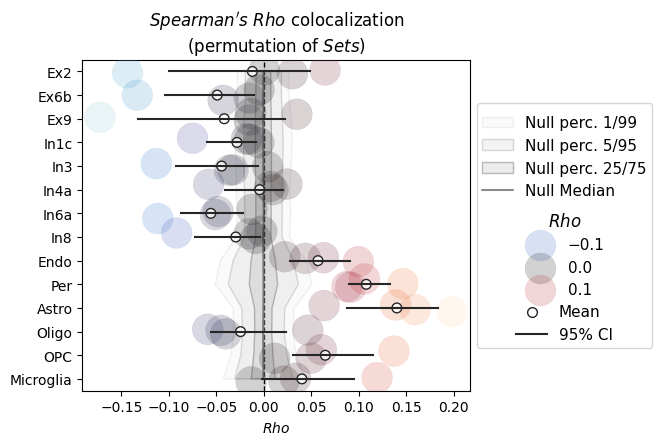

In [50]:
from nispace.workflows import simple_xsea

comparison = "holiga2019"

colocs[comparison], p_values[comparison], q_values[comparison], nsp_holiga2018 = simple_xsea(
    x=ref_data,
    x_background=ref_background,
    y=holiga_data,
    z="gm",
    n_perm=10000,
    parcellation=parc_name,
    standardize="xyz",
    init_kwargs={"y_labels": holiga_labels},
    verbose=False,
    n_proc=-1,
)

## Plot results

INFO | 17/06/24 10:12:17 | nispace: *** NiSpace.plot() - Plot colocalization results. ***
INFO | 17/06/24 10:12:17 | nispace: Creating categorical plot for method spearman, colocalization stat rho.
INFO | 17/06/24 10:12:17 | nispace: *** NiSpace.plot() - Plot colocalization results. ***
INFO | 17/06/24 10:12:17 | nispace: Creating categorical plot for method spearman, colocalization stat rho.
INFO | 17/06/24 10:12:17 | nispace: *** NiSpace.plot() - Plot colocalization results. ***
INFO | 17/06/24 10:12:17 | nispace: Creating categorical plot for method spearman, colocalization stat rho.


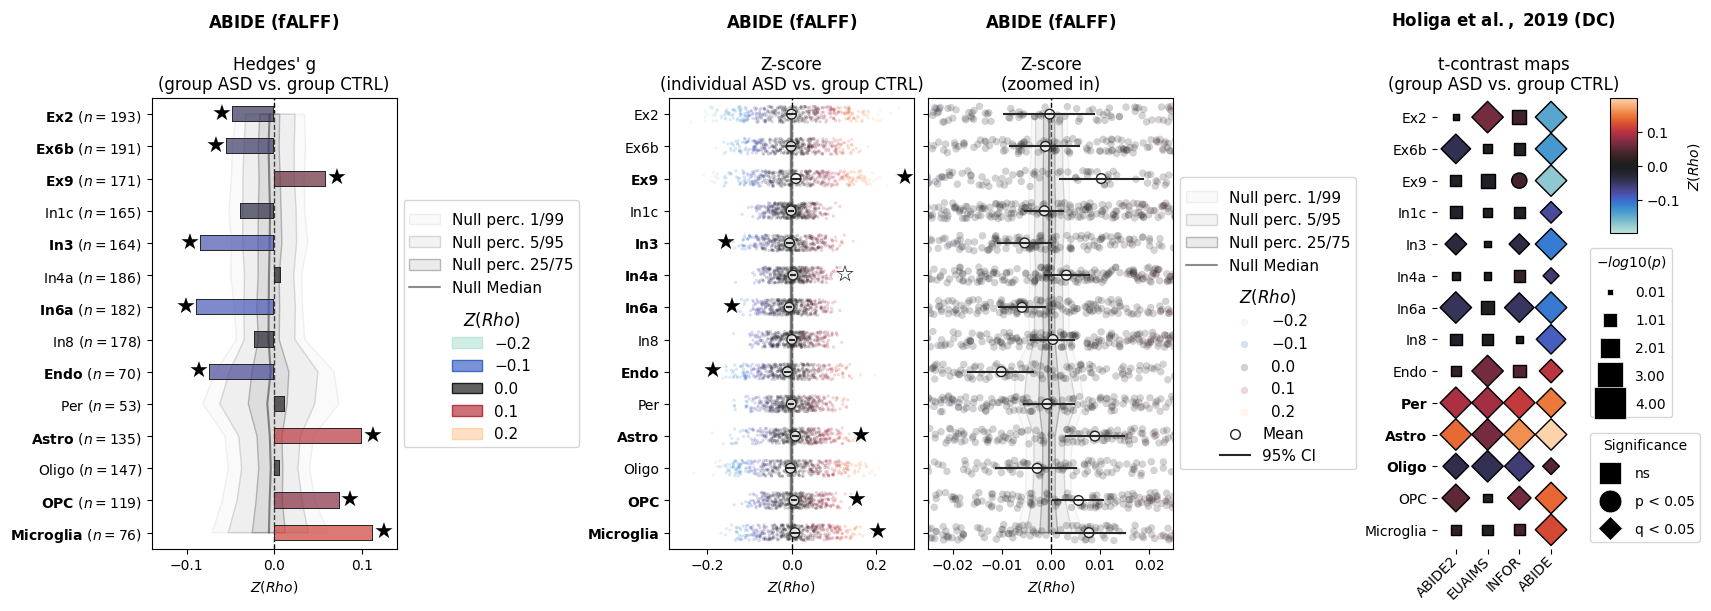

In [56]:
from nispace.plotting import print_significance
from nispace.plotting import heatmap

fig, axes = plt.subplots(1,4, figsize=(17, 6), constrained_layout=True)


## ABIDE PLOTS

for i, (comparison, title, x_lims) in enumerate([
    ("hedges(a,b)", "$\mathbf{ABIDE\ (fALFF)}$\n\nHedges' g\n(group ASD vs. group CTRL)", (-0.14, 0.14)), 
    ("zscore(a,b)", "$\mathbf{ABIDE\ (fALFF)}$\n\nZ-score\n(individual ASD vs. group CTRL)", (-0.29, 0.29)),
    ("zscore(a,b)", "$\mathbf{ABIDE\ (fALFF)}$\n\nZ-score\n(zoomed in)", (-0.025, 0.025))]):
    
    kwargs = {
        "fig": fig,
        "method": colocalization, 
        "Y_transform": comparison,
        "permute_what": "sets",
        "show": False,
    }

    # plot current comparison
    nsp.plot(
        ax=axes[i],
        title=title,
        **kwargs,   
        plot_kwargs={
            "legend": {
                "plot": False if i == 1 else True,
                "kwargs": {"title": "$Z(Rho)$"}
            },
            "limits": {
                "x": x_lims,
                "color": (-0.2, 0.2)
            },
            "scatters": {
                "size": 5 if i == 2 else 2
            }
        } ,
        nullplot_kwargs={
            "legend": {
                "plot": False if i == 1 else True
            }
        }
    )
    axes[i].set_xlabel("$Z(Rho)$")
    
    # labels for main plot
    if i in [0,1]:
        if i == 0:
            axes[i].set_yticks(
                labels=[f"{c} $(n = {ref_data_maps_pet_set[c]})$" for c in colocs[comparison].columns],
                ticks=range(colocs[comparison].shape[1])
            )
        # else:
        #     axes[i].set_yticks(
        #         labels=[f"{c} $(n = {ref_data_maps_pet_set[c]})$" for c in colocs[comparison].columns],
        #         ticks=range(colocs[comparison].shape[1])
        #     )
        print_significance(axes[i], coloc_values=colocs[comparison], p_values=p_values[comparison], 
                           q_values=q_values[comparison],
                           pq_positions_pad=0.012, pq_size=16)
    
    # no y labels for zoomed-in plot
    elif i==2:
        axes[i].set_yticklabels([])
        axes[i].set_xlabel("$Z(Rho)$")
    
## HOLIGA PLOT
ax = axes[-1]
ax.set_title("$\mathbf{Holiga\ et\ al.,\ 2019\ (DC)}$\n\nt-contrast maps\n(group ASD vs. group CTRL)")

significance_shapes = p_values["holiga2019"].copy().astype(str)
significance_shapes.iloc[:] = "ns"
significance_shapes = np.where(p_values["holiga2019"] < 0.05, "p < 0.05", significance_shapes)
significance_shapes = np.where(q_values["holiga2019"] < 0.05, "q < 0.05", significance_shapes)

heatmap(
    ax=ax,
    data_colors=colocs["holiga2019"].T,
    data_sizes=-np.log10(p_values["holiga2019"].T),
    data_shapes=significance_shapes.T,
    spines=None,
    linewidth=0.02,
    ytick_labels=colocs["holiga2019"].columns,
    xtick_labels=colocs["holiga2019"].index,
    legend_colors_kwargs={
        "label": "$Z(Rho)$",
        "cax": ax.inset_axes((1.3, 0.7, 0.2, 0.3))
    },
    legend_sizes_kwargs={
        "title": "$-log10(p)$",
        "bbox_to_anchor": (1.1, 0.48)
    },
    legend_shapes_kwargs={
        "title": "Significance",
        "bbox_to_anchor": (1.1, 0)
    },   
)

print_significance(ax, p_values=p_values["holiga2019"].max(axis=0), 
                   q_values=q_values["holiga2019"].max(axis=0))

# save
fig.savefig("abide_plot_main.pdf", bbox_inches="tight")
                